## Crater Detection
A reliable crater detection algorithm (CDA) is an important problem that is still unsolved.<br>
Crater statistics (count and size distributions) are important for planetary geology. Due to a wealth of high-resolution imaging on Mars, there has been an extensive effort to catalogue all of the visible craters on the red planet. Craters in greater than 1 km in diameter on Mars have been identified and documented exhaustively by one heroic effort by a researcher named <a href='https://astrogeology.usgs.gov/search/details/Mars/Research/Craters/RobbinsCraterDatabase_20120821/zip'>Stuart Robbins</a>. Once you start looking at craters smaller than 1 km in diameter, the task of hand-labeling every crater explodes; there are exponentially more craters of that size to deal with. The need for a reliable CDA becomes glaringly obvious.<br>
The most important work on this problem of the decade was arguably <a href='https://www.lpi.usra.edu/meetings/lpsc2010/pdf/1144.pdf'><I>Automatic Detection of Sub-km Craters using Shape and Texture Information</I></a> (2010 Bandiera et al.), which uses a two-step process to address the problem. The basic steps are:
 1. Identify "crater candidates" using shape filters.
 2. Classify candidates as craters or non-craters using Adaboost.
<br>


This research shows promising results, improving on previous algorithm performance. Importantly, the method opens the problem up to more researchers as a simple classification problem. Further progress on this binary classification problem is achieved in <a href='https://arxiv.org/pdf/1601.00978.pdf'><I>Crater Detection via Convolutional Neural Networks</I></a> (2016 Cohen et al.) This group is able to improve on the binary classification problem with an F1 score close to 90% on each of the three benchmark terrains on Mars.

## Outstanding Problems (Fodder for Capstone Project)
The general idea is to apply CNNs to this problem. Here are four possible approaches:

 1. Implimentation: Reproduce researchers' results (Bandiera et al. crater candidate recomendations, 2010, and Cohen et al. binary classification via neural nets, 2016) and create an accessible model/package for astronomers to utilize
 
 2. Improve on Bandiera et al. crater candidate identification work via Neural Nets (similar to: <a href='https://www.hou.usra.edu/meetings/lpsc2018/pdf/1948.pdf'>KerasCraterCNN</a>)
 
 3. Improve on <a href='https://arxiv.org/pdf/1601.00978.pdf'>Cohen's classification work</a> (F1 above 90 - plenty of room for improvement here.)
 
 4. Address other problem: hand-labeled craters (of this size) are hard to produce because you need a planetary geologist to do the labeling (no amateurs allowed.) There has been some work and talks about using synthetic planetary terrains to train such models. A cool project would be to follow <I><a href='http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf'>The Effectiveness of Data Augmentation in Image Classification using Deep Learning</a></I>, Wang & Perez, 2017 and create a platform for synthetic planetary terrain generation. The idea here would be to use GANN's to generate crater images, imbed these images into a solid color image, blend it via Wang & Perez' method with a crater-free planetary landscape of the desired resolution with a third, "crater-full" target landscape from the desired planet, long & lat, to produce massive training data for CDA.

## Potential Dataset: "The MNIST Of Crater Data"
A benchmark dataset for Mars is detailed below, a section of 6 tiles hand-labeled by an expert planetary geologist. This is the dataset used in all of the earlier mentioned papers.

In [164]:
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
from collections import OrderedDict
import random
import string
%matplotlib inline

## The Tiles
The grid is 2 tiles tall (N to S) and three tiles wide (E to W). An overview:

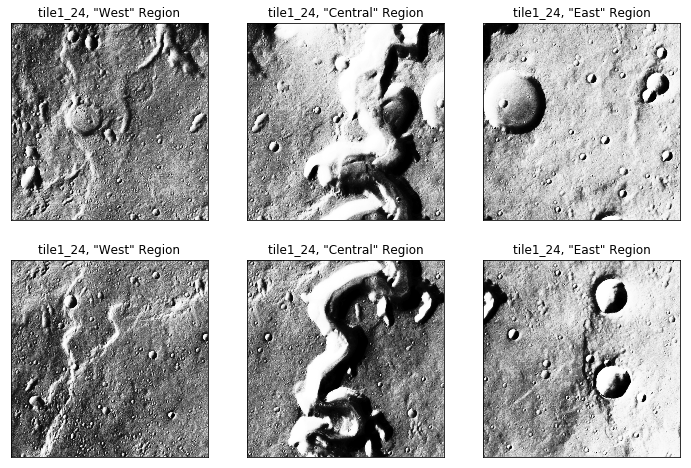

In [155]:
tile_names = [
    'tile1_24',
    'tile2_24',
    'tile3_24',
    'tile1_25',
    'tile2_25',
    'tile3_25',
]
regions = [
    '"West" Region',
    '"Central" Region',
    '"East" Region',
    '"West" Region',
    '"Central" Region',
    '"East" Region',
]

tiles = {}
for name in tile_names:
    num = name[4:]
    tiles[num] = PIL.Image.open(name + 's.pgm')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
axes = axes.reshape(6,)
for i, ax in enumerate(axes):
    ax.tick_params(
        axis='both', 
        which='both', 
        bottom='off', 
        top='off', 
        labelbottom='off', 
        right='off', 
        left='off', 
        labelleft='off'  # labels along the bottom edge are off
        )
    tile = tile_names[i][4:]
    ax.set_title(image_name + ', ' + regions[i])
    img = tiles[tile]
    ax.imshow(np.array(img), cmap='Greys')

Each tile is 1700x1700 pixels, and each pixel is 12.5 square meters of the Martian surface. There is some overlap between the tiles, but each tile covers about 450 square kilometers.

## "Ground Truth" Labels
The dataset consists of 3658 craters hand-labeled (I think) by Urbach in his 2009 paper, 

In [3]:
all_craters = pd.DataFrame(columns = ['x', 'y', 'd', 'tile'])
for tile in tile_names:
    num = tile[4:]
    new_craters = pd.read_csv('./gt_labels/{}_gt.csv'.format(num), header=None)
    new_craters.index = range(len(all_craters), len(all_craters)+len(new_craters))
    new_craters.columns = ['x', 'y', 'd']
    new_craters['tile'] = num
    all_craters = pd.concat([all_craters, new_craters], axis=0)
print('{} total number of labeled craters'.format(len(all_craters)))

3658 total number of labeled craters


In [5]:
demo_tile = '1_24'
img = tiles[demo_tile]

In [6]:
scale = .35

In [7]:
def plot_craters(tile, craters, title=None, scale=scale, colors=['r', 'y', 'cyan', 'o', 'g']):
    """Takes an input PIL image "tile" and a dictionary,
    with each key as a type of crater and its element a list
    of craters with form: (x, y, d) (xpos, ypos, diameter)
    """
    img = tile
    if not title:
        title = list(craters.keys())[0]
    size = (int(img.size[0]*scale/80), int(img.size[1]*scale/80))
    fig, ax = plt.subplots(figsize=size);
    ax.imshow(np.array(img), cmap='Greys');
    ax.set_title(title);
    ax.set_ylabel('N-S direction in pixels @12.5 meters/pixel')
    ax.set_xlabel('E-W direction in pixels @12.5 meters/pixel')
    for i, group in enumerate(craters):
        color = colors[i]
        for crater in craters[group]:
            x = crater[0]
            y = crater[1]
            r = crater[2]/2
            circle = plt.Circle((x, y), r, fill=False, color=color);
            ax.add_artist(circle);
    #ax.legend();
    plt.show();
    return None

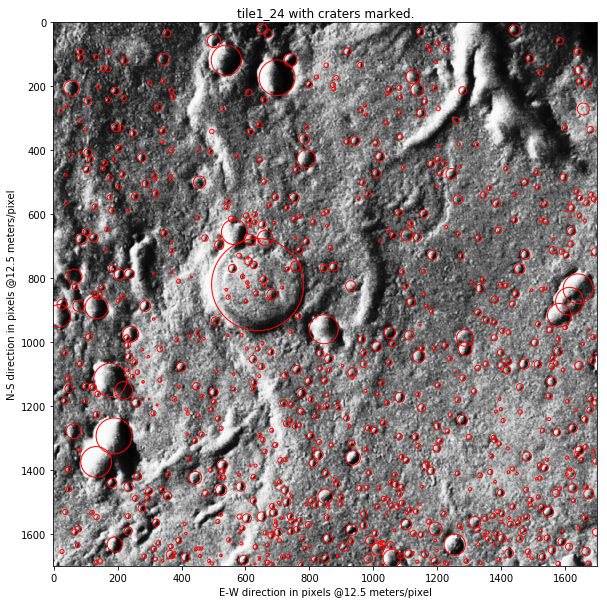

In [8]:
craters = all_craters[all_craters.tile=='1_24']
craters = {'craters': craters[['x', 'y', 'd']].values}
plot_craters(img, craters, title='{} with craters marked.'.format(image_name))

## Crater proposals dataset
There is also a craters proposal dataset. It includes a set of proposed craters, some of which are tru and some of which are false. These proposals, and the binary classification task of rejecting false proposals, has been used as a benchmark in numerous studies.

In [12]:
true_proposals = pd.DataFrame(columns = proposal_columns)
for tile in tile_names:
    num = tile[4:]
    new_proposals = pd.read_csv('./bandiera2010_candidates/{}_tp.csv'.format(num), header=None)
    new_proposals.columns = ['x', 'y', 'd']
    new_proposals.index = range(len(true_proposals), len(true_proposals)+len(new_proposals))
    new_proposals['tile'] = num
    true_proposals = pd.concat([true_proposals, new_proposals], axis=0)

In [14]:
false_proposals = pd.DataFrame(columns = proposal_columns)
for tile in tile_names:
    num = tile[4:]
    new_proposals = pd.read_csv('./bandiera2010_candidates/{}_tn.csv'.format(num), header=None)
    new_proposals.columns = ['x', 'y', 'd']
    new_proposals.index = range(len(false_proposals), len(false_proposals)+len(new_proposals))
    new_proposals['tile'] = num
    false_proposals = pd.concat([false_proposals, new_proposals], axis=0)

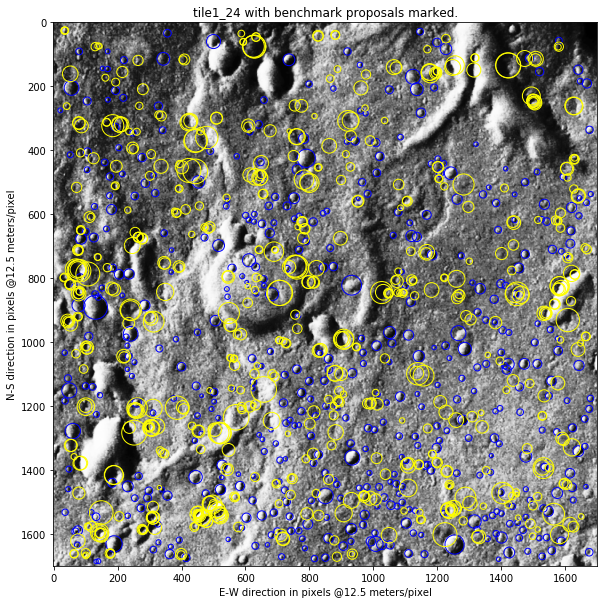

In [15]:
proposals = OrderedDict()
proposals['true proposals'] = true_proposals[true_proposals.tile=='1_24'][['x', 'y', 'd']].values
proposals['false proposals'] = false_proposals[false_proposals.tile=='1_24'][['x', 'y', 'd']].values
colors = ['blue', 'yellow']
title = '{} with benchmark proposals marked.'.format(image_name)
plot_craters(img, proposals, title=title, colors=colors)

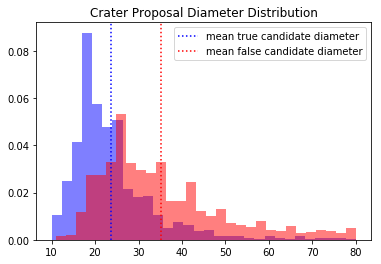

In [31]:
plt.hist(true_proposals.d.astype(int), bins=30, alpha=.5, normed=True, color='blue');
plt.axvline(x=true_proposals.d.mean(), color='blue', label='mean true candidate diameter', linestyle='dotted');
plt.hist(false_proposals.d.astype(int), bins=30, alpha=.5, normed=True, color='red');
plt.axvline(x=false_proposals.d.mean(), color='red', label='mean false candidate diameter', linestyle='dotted');
plt.title('Crater Proposal Diameter Distribution');
plt.xlabel('')
plt.legend();
plt.show();

In [154]:
def crop_crater(image, proposal):
    """Takes an input image of arbitrary size X, Y and a
    'crater', which is a tuplet (x, y, d) of a crater where
    x < X and y < Y. Returns a cropped image of dim 28x28 of
    the proposal.
    """
    x = proposal[0] #Record x and y positions
    y = proposal[1]
    r = max(14, proposal[2]) #"Radius" of image tbd
    #get four parameters of image box
    left = x - r
    upper = y - r
    right = x + r
    lower = y + r
    result = image.crop(box=(left, upper, right, lower))
    if result.size != (28, 28):
        result = result.resize((28, 28))
    return result

def invert_image(input_image):
    """inverts the input image color values. Returns image
    of same dim."""
    if not type(input_image) == type(np.array([0])):
        input_image = np.array(input_image)/256
    return (input_image - 256) * -1 

def normalize_image(input_image):
    """Takes a PIL image and "normalizes" its pixel values;
    returns a numpy array of same shape, with min value 0 and
    max value 256.
    """
    if not type(input_image) == type(np.array([0])):
        array = np.array(input_image)/256
    else:
        array = input_image
    min_ = np.min(np.min(array))
    array = array - min_
    max_ = np.max(np.max(array))
    array = array * 1/max_ * 256
    return array

In [190]:
df = pd.DataFrame(columns=['a', 'b', 'c'])
df['a'] = [1,2,3]
df['b'] = [1,2,3]
df['c'] = [1,2,3]
idx = df.sample(1).index
df.drop(idx, axis=0)

,a,b,c
0,1,1,1
2,3,3,3
